# Introduction to Image Access with GBDXTools

DigitalGlobe has created a python library called `gbdxtools`. This library acts as a general purpose set of tools for accessing various APIs and features of the GBDX Platform. This notebook is an introduction to a specific set of features in `gbdxtools` that are designed to provide direct access to various forms of imagery available from DigitalGlobe.

To explore the full capabilities that gbdxtools provides, refer to the <a target="_blank" href="http://gbdxtools.readthedocs.io/en/latest/index.html">gbdxtools documentation</a>.

### Content

* [Initializing an Image](#Finding-Imagery)
* [Reprojecting Images](#Reprojecting-Images)
* [Areas of Interest](#Areas-of-Interest)
* [Accessing Metadata](#Accessing-Metadata)
* [Viewing Images](#Viewing-Images)
* [Fetching data into Numpy Arrays](#Fetching-data-into-Numpy-Arrays)
* [Panchromatic and Multispectal Bands](#Panchromatic-and-Multispectal-Bands)
* [Pansharpening](#Pansharping)
* [Creating Geotiffs](#Creating-Geotiffs)

# Finding Imagery

Searching for imagery can be accomplished by searching the DigitalGlobe imagery "catalog". For the purposes of this demo we'll assume that we've already found an image we want to access by using the <a target="_blank" href="http://gbdxtools.readthedocs.io/en/latest/catalog_search.html">gbdxtools catalog search</a> to find an image `CatalogID`. Here we'll be using a WorldView3 image with a `CatalogID` of `104001002073CC00`. 

In [1]:
from gbdxtools import CatalogImage

catalog_id = '104001002073CC00'
image = CatalogImage(catalog_id)
image.shape

(8, 48771, 12608)

You can see the dimentions of the data we're working with (8 bands, 48771 rows, 12608 columns), but it's worth noting that pixel data has not been fetched from the server, only the metadata about the image dimension. Under the hood we're using <a href="https://dask.pydata.org/en/latest/" target="_blank">Dask</a> as the means for providing deferred access to the actual data. By leveraging dask we can treat the image as we would a numpy ndarray. We can index/slice the data, reshape it, and manipulate the data without fetching it until we need to access the actual data (ie when we want to plot or inspect actual data values).  

### Reprojecting Images

Image constructors except a `proj` parameter that will automatically reproject data into the given projection. Valid values for `proj` are `EPSG` codes in the form of: EPSG:4326, EPSG:3857, EPSG:36212, etc.

In [2]:
image = CatalogImage(catalog_id, proj="EPSG:3857")
image.shape

(8, 52627, 11646)

### Areas of Interest

Slicing our image can take a few forms. The most common form of subsetting an image is by defining an Area of Interest (AOI). By using an AOI to subset our image we're manipulating the array's shape to reflect the shape of the data the AOI. We can define as many AOIs as we want and only fetch the raw data when we need to (for instance when we want to look at it). Here our AOI is a bounding box in the form `[minx, miny, maxx, maxy]` in geographic coordinates. 

In [3]:
bbox = [121.49037837982179, 31.23682070567235, 121.49917602539062, 31.244067484256615]

aoi = image.aoi(bbox=bbox)
print 'AOI Shape:', aoi.shape

AOI Shape: (8, 647, 672)


You can see that the AOI's shape is much less than that of the full image. In addition to using a bounding box we can use a Well-Known-Text or GeoJSON object to define AOIs. The benefit of this strategy is that you take a single image strip and extract multiple AOIs very quickly, and without incurring the bandwidth cost of transferring data until we absolutely need to. 

### Accessing Metadata

The image classes in gbdxtools provide access to various metadata about the image including spatial data and other sensor acquisition attributes.  

In [4]:
print("CatID: {} instantiated as a {} {}-band raster with {} rows and {} columns".format(catalog_id, image.dtype, *image.shape))
print("  with geographic bounds: ({})".format(bbox))
print("  in projection: {}".format(image.ipe_metadata["georef"]["spatialReferenceSystemCode"]))
print("  at {:0.2f} meter resolution".format(image.ipe_metadata["image"]["groundSampleDistanceMeters"]))
print("  and {:0.2f} degrees off nadir".format(image.ipe_metadata["image"]["offNadirAngle"]))
print("  taken on {}".format(image.ipe_metadata["image"]["acquisitionDate"]))

CatID: 104001002073CC00 instantiated as a float32 8-band raster with 52627 rows and 11646 columns
  with geographic bounds: ([121.49037837982179, 31.23682070567235, 121.49917602539062, 31.244067484256615])
  in projection: EPSG:3857
  at 1.36 meter resolution
  and 18.50 degrees off nadir
  taken on 2016-07-21T02:51:57.352Z


All the image metadata, including georeferencing and RPCs info, are available on the `image.ipe_metadata` property:

In [5]:
import json
print json.dumps(image.ipe.metadata, indent=4)

{
    "georef": {
        "translateX": 13517955.38233803, 
        "translateY": 3686998.1639941586, 
        "scaleX": 1.4581859683601364, 
        "scaleY": -1.4581859683601364, 
        "shearY": 0.0, 
        "shearX": 0.0, 
        "spatialReferenceSystemCode": "EPSG:3857"
    }, 
    "image": {
        "maxX": 11646, 
        "maxY": 52627, 
        "satAzimuth": 133.1, 
        "sunAzimuth": 121.0, 
        "cloudCover": 0.0, 
        "imageId": "052f8429-f6c3-41d9-adab-7541017941b2", 
        "numYTiles": 206, 
        "numXTiles": 46, 
        "imageWidth": 11647, 
        "tileYSize": 256, 
        "sensorName": "8-band (Coastal, Blue, Green, Yellow, Red, Red-edge, NIR1, NIR2) Multispectral", 
        "minY": 0, 
        "maxTileX": 45, 
        "maxTileY": 205, 
        "minX": 0, 
        "vendorDatasetIdentifier": "LV1B:055511469010_01_P001:104001002073CC00:A0100101ECA89400", 
        "version": "1.0", 
        "numBands": 8, 
        "imageHeight": 52628, 
        "offNa

### Viewing Images

We can view AOIs by calling `aoi.plot()`. Each image comes with both an `rgb` and `plot` methods. These methods are helpers that determine how to display the image for previewing. If the image is a Panchromatic image it displays the single band, if its Multispectral data it attempts to render an RGB version of the image. You can pass `width` and `height` to the plot method to control the size of the rendered plot.

Note that calling plot will fetch data from the server, but it will only fetch the data for the AOI.

Additionally we can plot individual bands using `matplotlib` and standard numpy array indexing. 

Fetching Image... 9 tiles


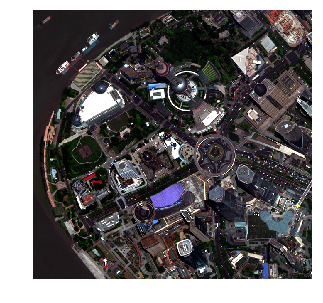

In [6]:
aoi.plot(w=5, h=5)

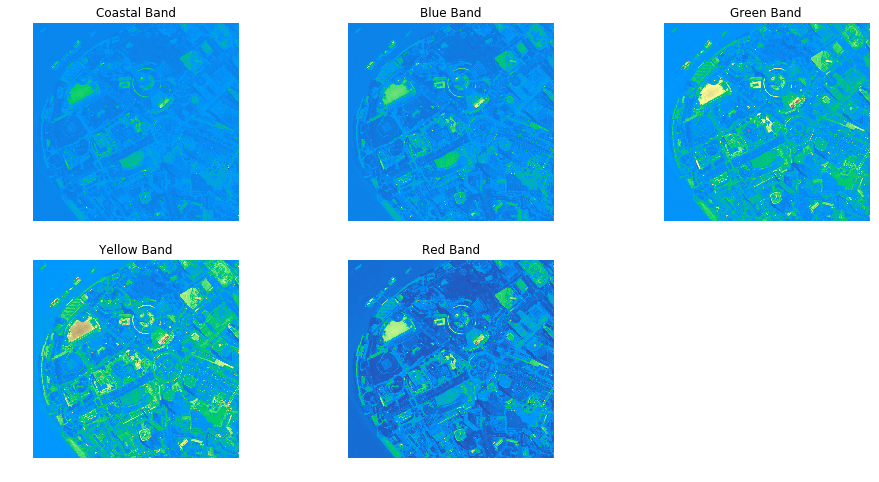

In [7]:
import matplotlib.pyplot as plt
bands = ["Coastal", "Blue", "Green", "Yellow", "Red"]
plt.figure(figsize=(16,8))
for i in xrange(5):
    plt.subplot(2, 3, i+1)
    plt.axis('off')
    plt.imshow(aoi[i,...], cmap="terrain")
    plt.title("{} Band".format(bands[i]))
plt.show()

### Fetching data into Numpy Arrays

The plot method above will automatically fetch what it needs from the server, but you can also fetch all data by calling the image's `read` method. By calling `read` we control how the data are fetched. In order to make the fetching of data as fast as possible we use parallel fetching to fetch many chunks of data from the server at once. This makes requests for larger areas as fast as possible. 

Calling `read` returns a numpy array <a target="_blank" href="http://www.numpy.org/">Numpy Array</a>, and allows us direct access to the raw pixel data of the image.

In [8]:
nd_array = aoi.read()
print nd_array.shape
print 'Max', nd_array.max()
print 'Mean', nd_array.mean()
print 'Min', nd_array.min()

Fetching Image... 9 tiles
(8, 647, 672)
Max 1.90497
Mean 0.17804
Min -0.00740534


### Panchromatic and Multispectal Bands

WorldView 2 and 3 images have both multispectral and panchromatic bands. By default 'gbdxtools.CatalogImage' will provide `multispectral` bands, but this controllable by passing the `band_type='MS|Pan'` parameter to the constructor.

Multispectral data are 8 bands (Coastal, Blue, Green, Yellow, Red, Red-edge, NIR1, NIR2) at approximately a 2 meter resolution. The panchromatic band is served as a single band image at ~.5 meter resolution. 

### Pansharpening

The term "pansharpening" refers to the process of combining lower resolution multispectral bands with the higher resolution panchromatic band. This results in a high resolution color image. To perform pansharpening on a CatalogImage you pass the keyword parameter `pansharpen=False|True`. The default is false. 

Fetching Image... 9 tiles


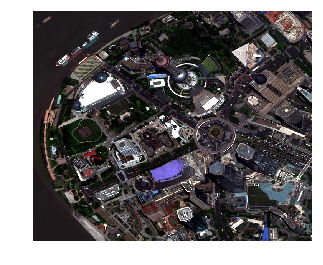

Fetching Image... 144 tiles


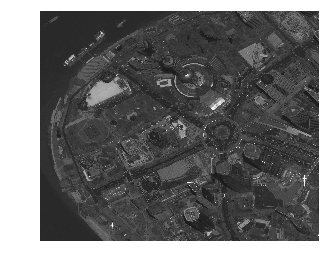

Fetching Image... 120 tiles


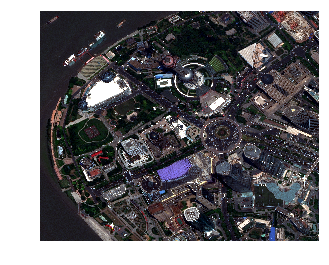

In [9]:
ms_img = CatalogImage(catalog_id, band_type='MS', bbox=bbox)
pan_img = CatalogImage(catalog_id, band_type='Pan', bbox=bbox)
psharp = CatalogImage(catalog_id, pansharpen=True, bbox=bbox)

ms_img.plot(w=5, h=5)
pan_img.plot(w=5, h=5)
psharp.plot(w=5, h=5)

### Creating Geotiffs

It can be useful for any number of reasons to save images to disk. Each image class provides a helper method that saves data as a valid GeoTiff file via the `image.geotiff` method. This method takes an optional `path`, `proj`, and `bands` arguments as well.

In [12]:
import numpy as np
tif = aoi.geotiff(path="aoi_rgb.tif", bands=[4,2,1], proj="EPSG:4326")
!gdalinfo {tif}

Driver: GTiff/GeoTIFF
Files: aoi_rgb.tif
Size is 672, 647
Coordinate System is:
GEOGCS["WGS 84",
    DATUM["WGS_1984",
        SPHEROID["WGS 84",6378137,298.257223563,
            AUTHORITY["EPSG","7030"]],
        AUTHORITY["EPSG","6326"]],
    PRIMEM["Greenwich",0],
    UNIT["degree",0.0174532925199433],
    AUTHORITY["EPSG","4326"]]
Origin = (13524245.996605535969138,3664486.689014615025371)
Pixel Size = (1.458185968360136,-1.458185968360136)
Metadata:
  AREA_OR_POINT=Area
Image Structure Metadata:
  INTERLEAVE=PIXEL
Corner Coordinates:
Upper Left  (13524245.997, 3664486.689) (Invalid angle,Invalid angle)
Lower Left  (13524245.997, 3663543.243) (Invalid angle,Invalid angle)
Upper Right (13525225.898, 3664486.689) (Invalid angle,Invalid angle)
Lower Right (13525225.898, 3663543.243) (Invalid angle,Invalid angle)
Center      (13524735.947, 3664014.966) (Invalid angle,Invalid angle)
Band 1 Block=256x256 Type=Float32, ColorInterp=Gray
Band 2 Block=256x256 Type=Float32, ColorInterp=Undef

Fetching Image... 9 tiles


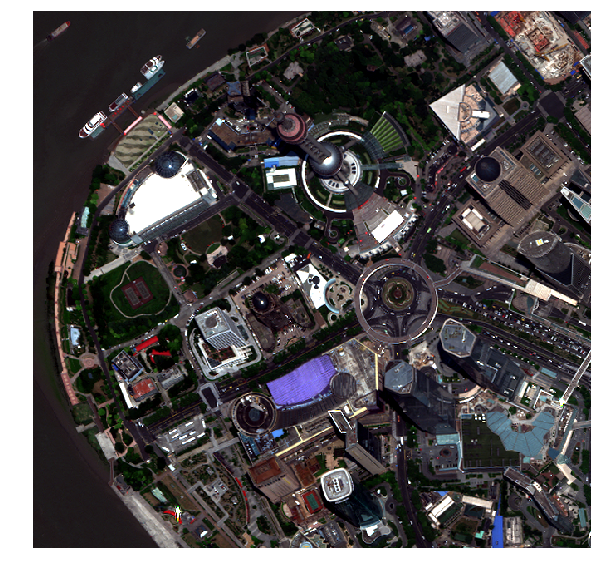

In [13]:
aoi.plot()